### Initial dimensions for graphics
* Sentence length = 5
* d_q, d_k, d_v = 3, 3, 3

## Attention is all you need

This article will delve into the fundamentals of self-attention, explaining its  
workings from the ground up. We'll embark on a step-by-step journey of coding it  
ourselves. Since its inception in the original transformer paper, "Attention Is  
All You Need," self-attention has emerged as a pivotal component in numerous  
cutting-edge deep learning models, especially within Natural Language Processing  
(NLP). Given its ubiquitous presence, grasping its mechanics is essential.


## Self-Attention

Self-attention, also known as intra-attention, allows neural networks to focus on  
different parts of input sequences simultaneously. It calculates the attention  
weights between different positions of a single sequence, enabling the model to  
weigh the importance of each input token based on its context within the sequence.  
This mechanism proves highly effective in capturing long-range dependencies and  
contextual information, making it a fundamental building block for various  
state-of-the-art models in Natural Language Processing (NLP) and other domains.

Self-attention serves as a mechanism to enrich the informational depth of an input  
embedding by integrating contextual information. Essentially, it empowers the model  
to assess the significance of various elements within an input sequence and  
adaptively modulate their impact on the output. Such functionality proves particularly  
crucial in language processing endeavors, where a word's significance can vary  
depending on its contextual placement within a sentence or document.

### Embedding an Input Sentence

In this NB the sentence to be followed through the self-attention mechanism is  
***When in doubt look intelligent***. The notebook can be run with any other sentence  
only then the visualizations will not be accurate. 

For processing this text, it first has to be embedded, i.e. put in a somehow meaningful  
representation of numbers. For simplicity, here our dictionary  dc is restricted  
to the words that occur in the input sentence. In a real-world application, we  
would consider all words in the training dataset (typical vocabulary sizes range  
between 30k to 50k).

In [39]:
sentence = 'When in doubt look intelligent'

In [40]:
dc = {s:i for i, s in enumerate(sorted(sentence.replace(',', '').split()))}
print(dc)

{'When': 0, 'doubt': 1, 'in': 2, 'intelligent': 3, 'look': 4}


Now an integer value is assigned to each word. (In this case according to the  
dictionary position)

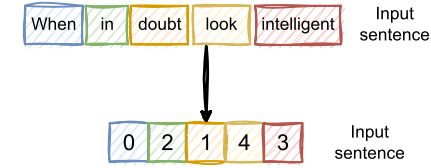

In [41]:
import torch

sentence_int = torch.tensor([dc[s] for s in sentence.replace(',', '').split()])

print('The sentence as integer values: ')
print(sentence_int)

The sentence as integer values: 
tensor([0, 2, 1, 4, 3])


The visual representation of that sentence can be given as:

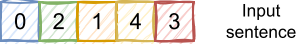

Using that integer value representation of the input sentence an embedding layer  
is used to encode the inputs into a real-vector embedding. The dimension of that  
embedding space can be chosen arbitrarily. For the visual representation i will  
use a 5-dimensional embedding.  

Since the input sentence consists of 5 words this will reuslt in a $5 \times 5$  
embedding matrix.

In [42]:
n_words_in_sentence = sentence_int.shape[0]
n_embedding_dimensions = 5

embed = torch.nn.Embedding(n_words_in_sentence, n_embedding_dimensions)
embedded_sentence = embed(sentence_int).detach()

print(embedded_sentence)
print(embedded_sentence.shape)

tensor([[ 1.1142,  0.0239, -1.0905,  0.1397,  0.5698],
        [ 0.8844,  0.4654,  0.8879,  0.7037,  0.5154],
        [ 0.9676,  2.0837,  0.4512,  0.2476,  0.0481],
        [ 1.5189, -0.7556,  0.9678,  0.9759,  1.6865],
        [-0.3008, -1.0099, -1.3379, -1.1475, -2.0809]])
torch.Size([5, 5])


Now the original input sentence looks like a matrix of shape $N_{Input Words} \times M_{Embeddings}$

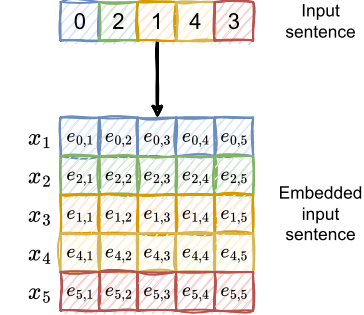

### Defining the weight matrices

In this notebook the most frequently and most impactful scaled-dot product attention  
mechanism will be discussed. This mechanism uses three weight matrices $\textbf{W}_q, \textbf{W}_k$  
and $\textbf{W}_v$ which are **adjusted as model parameters during training**.  
They are used as projection matrices to bring the inputs into key, query and value  
compontents of the sentence respectively.

The initialization of the weight matrices is below:

In [43]:
d =  embedded_sentence.shape[1]

#d_q, d_k, d_v = 24, 24, 28
d_q, d_k, d_v = 3, 3, 3


W_query = torch.nn.Parameter(torch.rand(d_q, d))
W_key = torch.nn.Parameter(torch.rand(d_k, d))
W_value = torch.nn.Parameter(torch.rand(d_v, d))

print(W_query.shape)
print(W_key.shape)
print(W_value.shape)

torch.Size([3, 5])
torch.Size([3, 5])
torch.Size([3, 5])


The randomly initialized weigt matrices

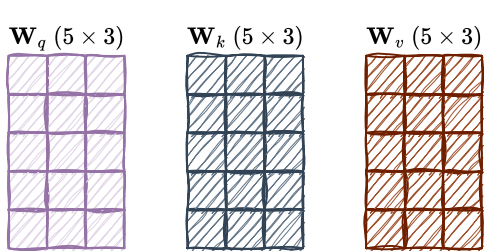


The respective query, key and value sequences are obtained via matrix multiplication  
between the weight matrices $\textbf{W}$ and the embedded inputs $\textbf{x}$.

* Query sequence: $\textbf{q}^{(i)} = \textbf{W}_q \cdot \textbf{x}^{(i)}$ for $i \in [1, T]$
* Key sequence: $\textbf{k}^{(i)} = \textbf{W}_k \cdot \textbf{x}^{(i)}$ for $i \in [1, T]$
* Value sequence: $\textbf{v}^{(i)} = \textbf{W}_v \cdot \textbf{x}^{(i)}$ for $i \in [1, T]$

The index $i$ refers to the token index position in the input sequence of length $T$. 


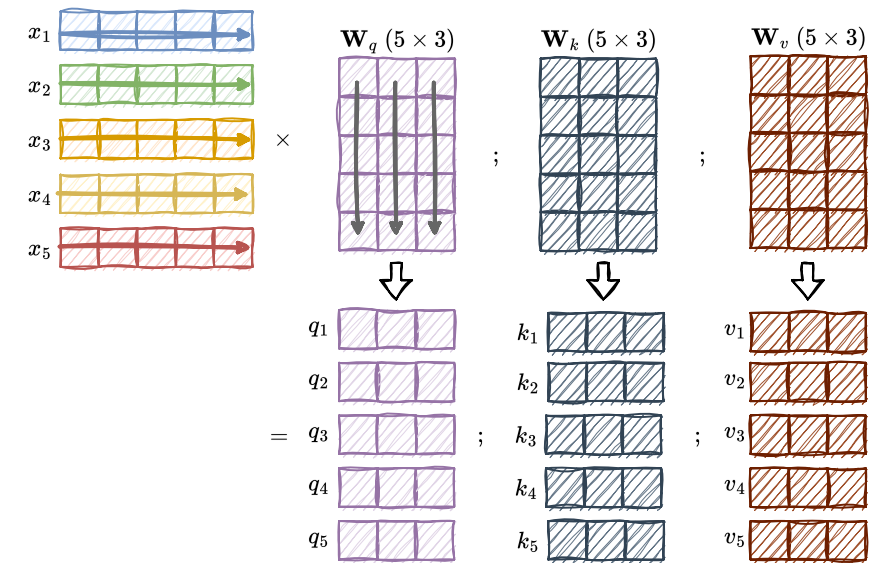


Both $\textbf{q}_i$ and $\textbf{k}_i$ are vectors of dimension $d_k$. The projection  
matrices $\textbf{W}_q$ and $\textbf{W}_k$ have a shape of $d_x \times d$, while $\textbf{W}_v$ has the  
shape $d_v \times d$.

(It’s important to note that $d$ represents the size of each word vector, $\textbf{x}$)

Since we are computing the dot-product between the query and key vectors, these  
two vectors have to contain the same number of elements $(d_q = d_k)$.  
However the number of elements in the value vector $\textbf{v}_i$, which determines the  
size of the resulting context vector is arbitrary.

(In this code walkthrough we will set $d_q=d_k=d_v=3$; This matches the supplied  
graphics; Feel free to alter that after you downloaded the notebook.)

### Computing the unnormalized attention weights

Lets now focus on the attention-vector of the second input element, which is the  
embedded sequence for the word <span style="color:green">**in**</span>. As we "follow" this element it's resulting  
element of the multiplication with $x_2 \times \textbf{W}_q = \textbf{q}_2$ acts as `query`.

In [44]:
x_2 = embedded_sentence[1]
print(x_2)

tensor([0.8844, 0.4654, 0.8879, 0.7037, 0.5154])


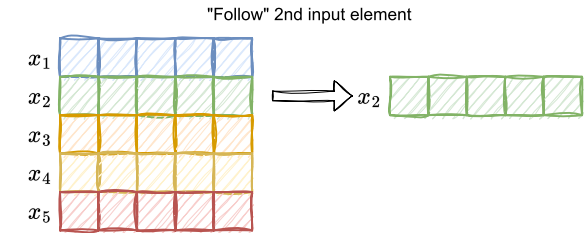

In [45]:
query_2 = W_query.matmul(x_2)
key_2 = W_key.matmul(x_2)
value_2 = W_value.matmul(x_2)

print(query_2.shape)
print(key_2.shape)
print(value_2.shape)

torch.Size([3])
torch.Size([3])
torch.Size([3])


We use that element to compute the respective `query`, `key` and `value` elements  
as shown below.

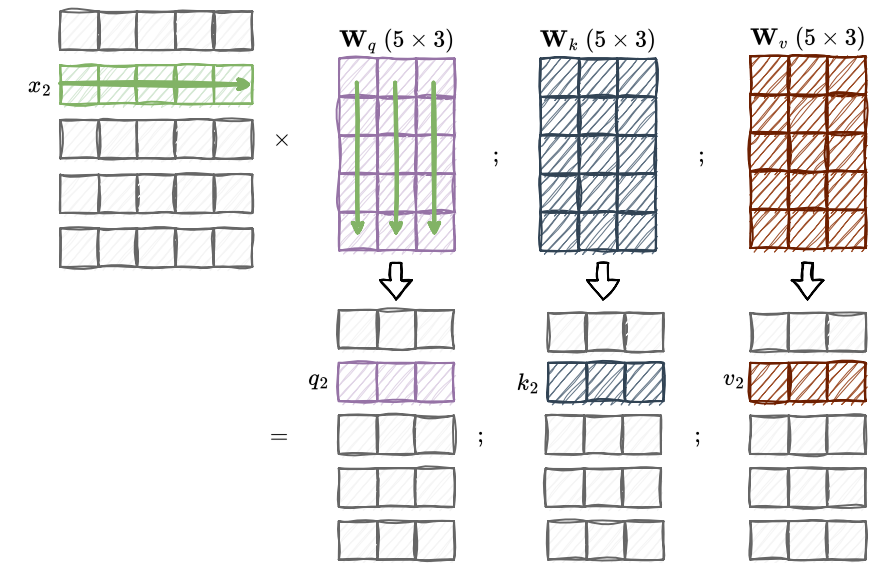

To generalize these computations for all input elements, the embeddings as well  
as calculated `querys`, `keys` and `values` are grouped together as matrices.


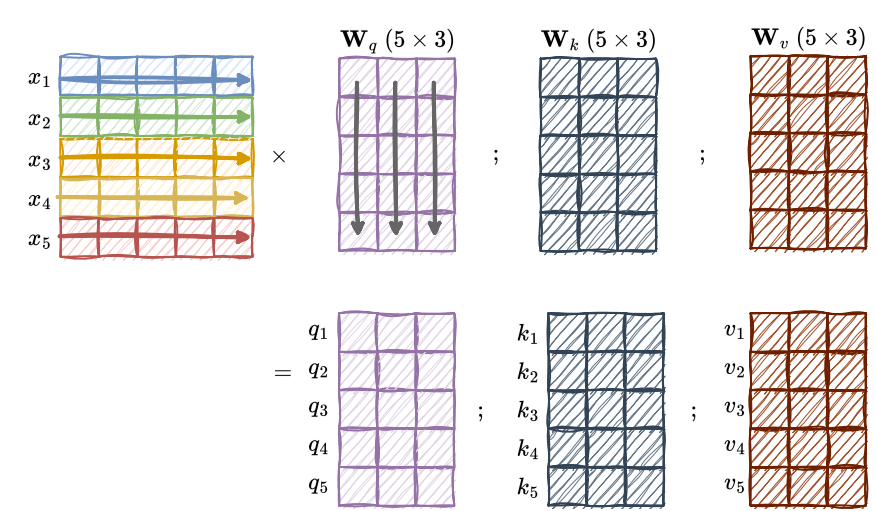

In [46]:
keys = W_key.matmul(embedded_sentence.T).T  
values = W_value.matmul(embedded_sentence.T).T

print('keys.shape: ', keys.shape)
print('values.shape: ', values.shape)

keys.shape:  torch.Size([5, 3])
values.shape:  torch.Size([5, 3])


Now all required `keys`, `queries` and `values` are calculated and we can proceed  
to the next step, which is computing the **unnormalized attention weights** $\omega$.

This is done as the dot-product between the `query` and `key` vectors $\omega_{i,j} = \textbf{q}_i \cdot \textbf{k}_j^T$.

As example, below the unnormalized attention weights for the `query` (remember $\textbf{q}_2$)  
and 5th input element (corresponding index position 4) is caclulated as follows:


In [47]:
omega_24 = query_2.dot(keys[4])
print(omega_24)

tensor(-18.1217, grad_fn=<DotBackward0>)


This can be visualized as follows:

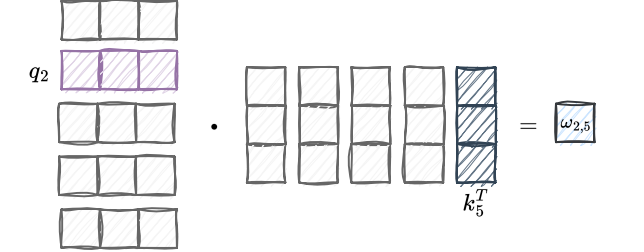

Since the output will be needed to compute the attention scores later, these  
calculations are generalized as before for each `key`.  

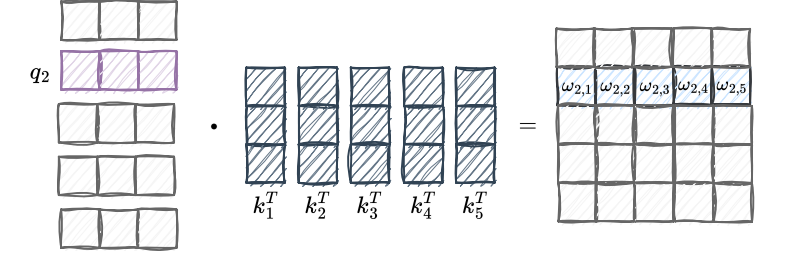

In [48]:
omega_2 = query_2.matmul(keys.T)
print(omega_2)

tensor([  2.8315,  10.0277,  10.8343,  13.3288, -18.1217],
       grad_fn=<SqueezeBackward4>)


Again this is generalized for the whole query and key matrices as the calculation $\textbf{W}_q \times \textbf{W}_k^T$  
which is visualized below

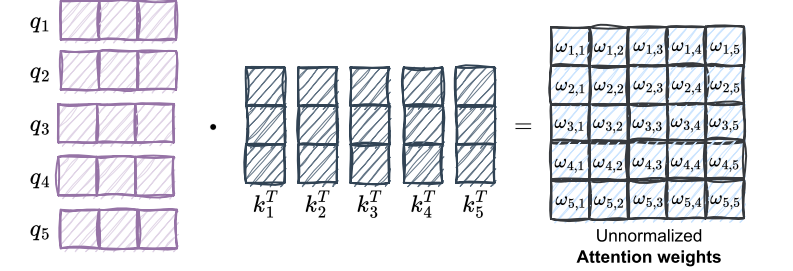

### Computing the attention scores

The calculated unnormalized attention weights are now normalized to obtain the  
**normalized attention weights** $\alpha$. This is done by applying the softmax  
function. Usually the unnormalized weights are also scaled before applying the  
softmax to account for numerical stability. In the original transformers paper  
this is done via $1/\sqrt{d_k}$

$\alpha_{2, j} = \text{softmax} \Large(\frac{\omega_{2,i}}{\sqrt{d_k}})$

This can be visualized as follows:

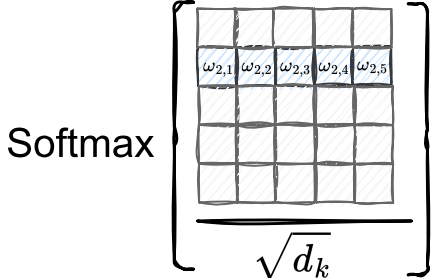

In [49]:
import torch.nn.functional as F

attention_weights_2 = F.softmax(omega_2 / d_k**0.5, dim=0)

print(attention_weights_2)


tensor([1.6809e-03, 1.0713e-01, 1.7068e-01, 7.2051e-01, 9.3700e-09],
       grad_fn=<SoftmaxBackward0>)


Again for efficiency this is generalized for the whole matric of unnormalized  
attention weights $\textbf{W}_q \times \textbf{W}_k^T$.

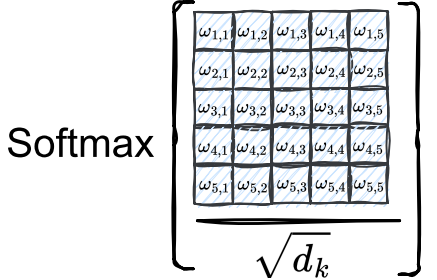

The last step is to compute the context vector $\textbf{z}_2$, which is an attention  
weighted version of the original query input $\textbf{x}_2$, including all the other  
input elements as its context via the attention weights:

$\textbf{z}_2 = \large\sum_{j=1}^T \alpha_{2,j} \cdot \textbf{v}_j$

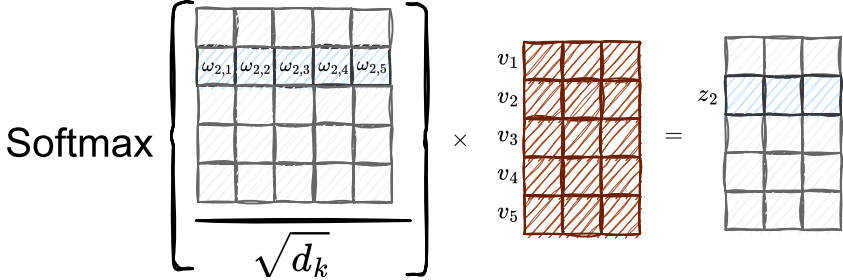

In [50]:
context_vector_2 = attention_weights_2.matmul(values)
print(context_vector_2.shape)
print(context_vector_2)

torch.Size([3])
tensor([1.5238, 1.6015, 1.2526], grad_fn=<SqueezeBackward4>)


Basically this is just another matrix multiplication of the resulting matrix from  
$\textbf{W}_q \times \textbf{W}_k^T$ with $\textbf{W}_v$ as depicted below.

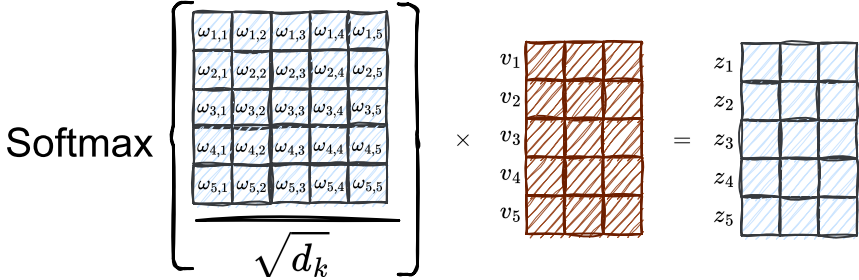

---

## Attention Scores

This section takes a closer look at the attention scores.  
As we have seen earlier, the attention filter is calculated via the operation: $\text{softmax} \large(\frac{\textbf{W}_q \times \textbf{W}_k^T}{\sqrt{d_k}})$.  
In this example the attention scores $\textbf{W}_q \times \textbf{W}_k^T$ before the softmax and scaling operation  
can be depicted in the visualizaiton below:

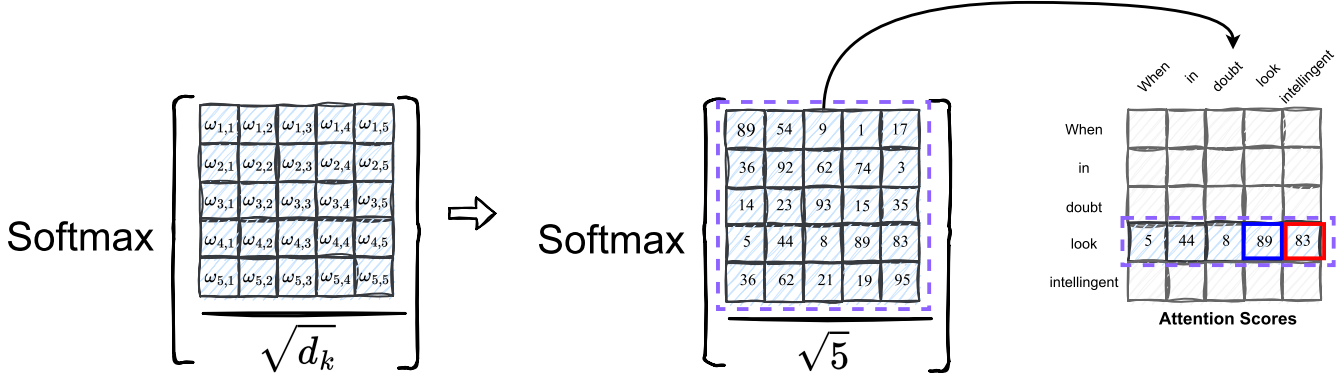

Lets consider the row corresponding to the word <span style="color:blue">**look**</span>. The highest attention  
a word pays is usually to itself, since it is the most similar to itself.  
The next highest attention score is given to the word which's embeddings are the  
most similar to the embeddings of the considered word. In the above example that  
word is <span style="color:red">**intelligent**</span>.

This can be interpreted that the word look is likely to be highly relevant  
in the context with the word intellingent. It suggests that this word-combination  
carries crucial information or meaning for understanding the overall message.

After applying the scaling and softmax operation the resulting matrix is calles  
an **attention filter**.

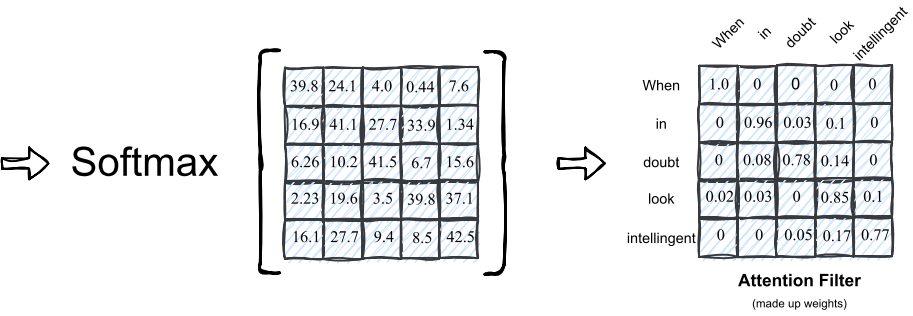

This attention filter is then as depicted above multiplied with the values or $\textbf{W}_v$

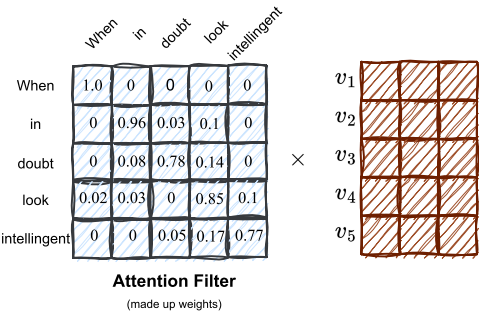

This process filters out the unnecessary backgroung information and focuses on what  
truly matters in that moment and that context.

Intuitively this can be thought of as demonstrated in the following image:

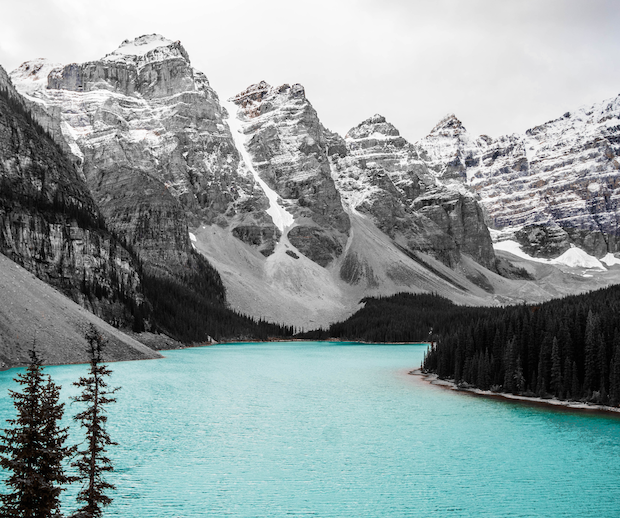